In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import pandas as pd
from scipy.stats import rankdata, mannwhitneyu

## Bug Analysis

In [2]:
def get_stack_trace(log_lines):
    started = False
    stack_traces_lines = []
    cur_stack_trace = []
    for line in log_lines:
        if "Backtrace:" in line:
            started = True
            cur_stack_trace = []
            continue
        if line.strip() == "" and started:
            stack_traces_lines.append([line for line in cur_stack_trace])
            cur_stack_trace = []
            started = False
        if not started:
            continue

        stripped_line = line.strip()
        if stripped_line != "":
            cur_stack_trace.append(stripped_line)
    
    stack_traces = []
    for stack_trace_lines in stack_traces_lines:
        pattern = "(.*)(\(.*\)?)(\[.*\])"
        stack_trace = []
        stack_trace_key = ""
        for line in stack_trace_lines:
            m = re.match(pattern, line)
            if m is None or len(m.group(0)) != len(line):
                continue
            call_file = m.group(1)
            func_call = m.group(2)
            if "redis-server" in call_file:
                call_file = "redis-server"
            if "linux" in call_file:
                continue
            func_call = func_call.strip("()")
            fname = ""
            addr = func_call.strip("()").strip("+")
            if "+" in func_call:
                [fname, addr] = func_call.split("+")
            stack_trace.append("{},{},{}\n".format(call_file, fname, addr))
            stack_trace_key += "{},{};".format(call_file,fname)
        stack_traces.append((hash(stack_trace_key), stack_trace))
        
    return stack_traces


In [3]:
def get_assertion_failures(log_lines):
    assertion_failures = []
    for i in range(len(log_lines)):
        line = log_lines[i]
        if "assertion failed" in line.lower():
            continue
        elif "pthread" in line.lower():
            continue
        elif "e == 0" in line.lower():
            assertion_failures.append(line.split("#")[1])
        elif "ety != null" in line.lower():
            assertion_failures.append(line.split("#")[1])
        elif "assertion" in line.lower():
            assertion_failures.append(line)
    return assertion_failures

def is_phread_failure(log_lines):
    for line in log_lines:
        if "___pthread_mutex_lock: assertion" in line.lower():
            return True
    return False

In [5]:
runs = [("new_experiments",i) for i in range(20)]

all_bugs = {}

all_assertion_failures = {
    "NO_ASSERTION_FAILURE": [],
}

failure_count = 0
mutex_fail_count = 0
no_assertion_fail_count = 0

for (folder, r) in runs:
    for file in os.listdir(os.path.join(folder, str(r))):
        sp = file[0:-4].split("_")
        if len(sp) != 2:
            continue
        [cat, iter] = sp

        failure_count += 1

        with open(os.path.join(folder, str(r),file), encoding = "ISO-8859-1") as log:
            log_lines = log.readlines()
            if is_phread_failure(log_lines):
                mutex_fail_count += 1
            stack_traces = get_stack_trace(log_lines)
            for key, stack_trace in stack_traces:
                if key == 0:
                    continue
                if key not in all_bugs:
                    all_bugs[key] = {
                        "occurrences": [],
                        "trace": stack_trace,
                    }
                all_bugs[key]["occurrences"].append((r, cat, iter))
            cur_assertion_failures = get_assertion_failures(log_lines)
            if len(cur_assertion_failures) == 0:
                no_assertion_fail_count += 1
                all_assertion_failures["NO_ASSERTION_FAILURE"] += [(r, cat, iter)]
                
            # Use all assertion failures
            for assertion_failure in cur_assertion_failures:
                if assertion_failure not in all_assertion_failures:
                    all_assertion_failures[assertion_failure] = []
                all_assertion_failures[assertion_failure] += [(r, cat, iter)]
                
            # Use only the first assertion failure
            # if len(cur_assertion_failures) > 0:
            #     assertion_failure = cur_assertion_failures[0]
            #     if assertion_failure not in all_assertion_failures:
            #         all_assertion_failures[assertion_failure] = []
            #     all_assertion_failures[assertion_failure] += [(r, cat, iter)]


In [6]:
print("Total runs: {}".format(failure_count))
print("Mutex failures: {}".format(mutex_fail_count))
print("No assertion failures: {}".format(no_assertion_fail_count))

Total runs: 117484
Mutex failures: 897
No assertion failures: 31366


In [7]:
filtered_bugs = {}
for k, v in all_bugs.items():
    ignore = False
    for line in v["trace"]:
        if "testSendMemberShipEvent" in line:
            ignore = True
            break
    if not ignore:
        filtered_bugs[k] = v

all_bugs = filtered_bugs

In [8]:
with open("assertion_failures.json", "w") as bugs_file:
    json.dump(all_assertion_failures, bugs_file, indent=4)
    
with open("bugs.json", "w") as bugs_file:
    json.dump(all_bugs, bugs_file, indent=4)

with open("bug_traces.json", "w") as bugs_file:
    bugs_traces = {}
    for k, v in all_bugs.items():
        bugs_traces[k] = v["trace"]
    json.dump(bugs_traces, bugs_file, indent=4)

In [9]:
len(all_bugs)

3815

In [10]:
# Retrieve the bug class for a given stack trace
def get_bug_class(trace):
    full_trace = "".join(trace)
    bug_class = "unclassified"
    if ",redis_test_" in full_trace or "base64Encode" in full_trace:
        bug_class = "ignore"
    elif "raft_restore_log" in full_trace or "callRaftPeriodic" in full_trace:
        bug_class = "raft_restore_log"
    elif "raft_node_set_addition_committed" in full_trace:
        bug_class = "raft_apply_entry"
    elif "raft_get_entry_from_idx" in full_trace:
        bug_class = "raft_get_entry_from_idx"
    elif "handleBeforeSleep" in full_trace or "raft_flush" in full_trace:
        bug_class = "handleBeforeSleep"
    elif "raft_node_set_addition_committed" in full_trace:
        bug_class = "raft_node_set_addition_committed"
    elif "raft_node_set_snapshot_offset" in full_trace:
        bug_class = "raft_node_set_snapshot_offset"
    elif "raft_append_entry" in full_trace or "raftNotifyMembershipEvent" in full_trace or "raft_entry_new" in full_trace:
        bug_class = "raft_append_entry"
    elif "ConnIsConnected" in full_trace or "callHandleNodeStates" in full_trace or "HandleNodeStates" in full_trace:
        bug_class = "ConnIsConnected"
    elif "raft_become_follower" in full_trace and "raft_recv_requestvote_response" in full_trace:
        bug_class = "raft_become_follower_requestvote_response"
    elif "raft_become_follower" in full_trace:
        bug_class = "raft_become_follower"
    elif "clientsCron" in full_trace:
        bug_class = "clientsCron"
    elif "raft_set_current_term" in full_trace and "raft_recv_appendentries" in full_trace:
        bug_class = "raft_set_current_term_appendentries"
    elif "raft_set_current_term" in full_trace and "raft_recv_requestvote_response" in full_trace:
        bug_class = "raft_set_current_term_requestvote_response"
    elif "raft_set_current_term" in full_trace and "raft_recv_requestvote" in full_trace:
        bug_class = "raft_set_current_term_requestvote"
    elif "raft_delete_entry_from_idx" in full_trace:
        bug_class = "raft_delete_entry_from_idx"
    elif "redis_test_http_do" in full_trace or "get_message_id" in full_trace or "mg_mgr" in full_trace or "deserializeAEReq" in full_trace:
        bug_class = "ignore"
    elif "libjson-c.so.5" in full_trace or "redis_test_cdeque" in full_trace or "redisraft.so" not in full_trace or "printCrashReport" in full_trace:
        bug_class = "ignore"
    return set([bug_class])


In [11]:
merged_bugs = {}
many_bug_classes_count = 0

for k, v in all_bugs.items():
    bug_classes = get_bug_class(v["trace"])

    if "ignore" in bug_classes:
        continue
    if len(bug_classes) > 1:
        many_bug_classes_count += 1
        
    for bug_class in bug_classes:
        if bug_class not in merged_bugs:
            merged_bugs[bug_class] = {
                "keys": [],
                "occurrences": [],
                "traces": [],
            }
        merged_bugs[bug_class]["keys"].append(k)
        merged_bugs[bug_class]["occurrences"] += v["occurrences"]
        merged_bugs[bug_class]["traces"].append(v["trace"])

with open("merged_bugs.json", "w") as bugs_file:
    json.dump(merged_bugs, bugs_file, indent=4)

print("All bugs: {}".format(len(all_bugs)))
print("Many bug classes: {}".format(many_bug_classes_count))

accounted_bugs = set()
unaccounted_bugs = {}

for k, v in merged_bugs.items():
    if k == "unclassified":
        continue
    for (r, cat, iter) in v["occurrences"]:
        accounted_bugs.add("{}_{}_{}".format(r, cat, iter))

for (r, cat, iter) in merged_bugs["unclassified"]["occurrences"]:
    key = "{}_{}_{}".format(r, cat, iter)
    if key not in accounted_bugs:
        filepath = os.path.join("new_experiments", str(r), "{}_{}.log".format(cat, iter))
        with open(filepath, encoding="ISO-8859-1") as log_file:
            log_lines = log_file.readlines()
            if "raft_restore_log" in "".join(log_lines):
                merged_bugs["raft_restore_log"]["occurrences"].append((r, cat, iter))
            else:
                print("Unaccounted bug: {}".format(key))
                unaccounted_bugs[key] = get_stack_trace(log_lines)
            

with open("unaccounted_bugs.json", "w") as unaccounted_file:
    json.dump(unaccounted_bugs, unaccounted_file, indent=4)

with open("unclassified_traces.json", "w") as unclassified_file:
    json.dump(merged_bugs["unclassified"]["traces"], unclassified_file, indent=4)

All bugs: 3815
Many bug classes: 0
Unaccounted bug: 14_random_29473
Unaccounted bug: 18_tlc_4558
Unaccounted bug: 4_trace_11991
Unaccounted bug: 10_random_23435
Unaccounted bug: 12_tlc_7602
Unaccounted bug: 14_line_26640
Unaccounted bug: 16_trace_10139
Unaccounted bug: 5_trace_6807
Unaccounted bug: 14_random_29473
Unaccounted bug: 9_line_987
Unaccounted bug: 17_tlc_16193


In [12]:
# hardcoded classification of unaccounted bugs

unaccounted_bug_classes = {
    "14_random_29473" : "raft_get_entry_from_idx",
    "4_trace_11991": "raft_get_entry_from_idx",
    "10_random_23435": "raft_get_entry_from_idx",
    "12_tlc_7602": "raft_get_entry_from_idx",
    "14_line_26640": "raft_get_entry_from_idx",
    "16_trace_10139": "raft_get_entry_from_idx",
    "14_random_29473": "raft_get_entry_from_idx",
    "17_tlc_16193":"raft_get_entry_from_idx",
}

for key, stack_trace in unaccounted_bugs.items():
    if key not in unaccounted_bug_classes:
        print("Unaccounted bug: {}".format(key))
        continue
    bug_class = unaccounted_bug_classes[key]
    if bug_class not in merged_bugs:
        merged_bugs[bug_class] = {
            "keys": [],
            "occurrences": [],
            "traces": [],
        }
    r, cat, iter = key.split("_")
    merged_bugs[bug_class]["occurrences"] += [(int(r), cat, int(iter))]
    merged_bugs[bug_class]["traces"].append(stack_trace)

Unaccounted bug: 18_tlc_4558
Unaccounted bug: 5_trace_6807
Unaccounted bug: 9_line_987


In [13]:
bug_categories = list(merged_bugs.keys())
print(len(bug_categories))
for b in bug_categories:
    occur = merged_bugs[b]["occurrences"][0]
    print("{}: {}_{}_{}".format(b, occur[0], occur[1], occur[2]))


15
raft_restore_log: 0_tlc_8976
raft_get_entry_from_idx: 0_tlc_721
unclassified: 0_tlc_12657
raft_append_entry: 0_random_7035
raft_apply_entry: 0_tlc_697
ConnIsConnected: 0_trace_1197
clientsCron: 0_tlc_12320
raft_node_set_snapshot_offset: 0_trace_16275
handleBeforeSleep: 1_tlc_5076
raft_become_follower_requestvote_response: 1_tlc_9807
raft_become_follower: 3_tlc_8554
raft_set_current_term_appendentries: 3_tlc_5709
raft_delete_entry_from_idx: 4_line_9130
raft_set_current_term_requestvote_response: 5_tlc_862
raft_set_current_term_requestvote: 7_tlc_6563


In [21]:
bug_stats = {}

bug_identifiers = {
    1 : "raft_get_entry_from_idx",
    2 : "raft_append_entry",
    3 : "raft_restore_log",
    4 : "ConnIsConnected",
    5 : "raft_apply_entry",
    6 : "clientsCron",
    7 : "raft_delete_entry_from_idx",
    8 : "raft_node_set_snapshot_offset",
    9 : "handleBeforeSleep",
    10 : "raft_become_follower",
    11 : "raft_become_follower_requestvote_response",
    12 : "raft_set_current_term_appendentries",
    13 : "raft_set_current_term_requestvote",
    14 : "raft_set_current_term_requestvote_response"
}

_cov_guidance_order = ["tlc", "random", "trace", "line"]

for id in range(1,15):
    cat = bug_identifiers[id]
    v = merged_bugs[cat]
    occurrences = set(v["occurrences"])
    found_runs = {}
    first_occur = {}
    for (r, cov_guidance, iter) in occurrences:
        if cov_guidance not in found_runs:
            found_runs[cov_guidance] = set()
        if cov_guidance not in first_occur:
            first_occur[cov_guidance] = {}
        found_runs[cov_guidance].add(r)
        if r not in first_occur[cov_guidance]:
            first_occur[cov_guidance][r] = int(iter)
        else:
            first_occur[cov_guidance][r] = min(first_occur[cov_guidance][r], int(iter))
    print(str(id)+",", end=" ")
    bug_stats[cat] = {
        "runs": {},
        "avg_first_occur": {},
        "first_occur": {},
    }

    for cov_guidance, runs in found_runs.items():
        bug_stats[cat]["runs"][cov_guidance] = len(runs)
    for cov_guidance, runs in first_occur.items():
        avg_runs = np.mean(list(runs.values()))
        std_runs = np.std(list(runs.values()))
        bug_stats[cat]["first_occur"][cov_guidance] = runs
        bug_stats[cat]["avg_first_occur"][cov_guidance] = avg_runs

    for cov_guidance in _cov_guidance_order:
        _runs = 0
        if cov_guidance in bug_stats[cat]["runs"]:
            _runs = bug_stats[cat]["runs"][cov_guidance]
        _avg_first_occur = 0
        if cov_guidance in bug_stats[cat]["avg_first_occur"]:
            _avg_first_occur = bug_stats[cat]["avg_first_occur"][cov_guidance]
        print(" {}({}),".format(str(int(_avg_first_occur)), _runs),end=" ")

    print("")

1,  299(20),  227(20),  368(20),  256(17), 
2,  10409(15),  13420(13),  8518(11),  7592(10), 
3,  48(20),  19(20),  32(20),  43(17), 
4,  10255(17),  12823(18),  11600(18),  10581(14), 
5,  578(20),  696(20),  945(20),  482(17), 
6,  8334(3),  0(0),  0(0),  17784(1), 
7,  6925(1),  14345(4),  0(0),  6512(2), 
8,  0(0),  0(0),  16275(1),  0(0), 
9,  11155(16),  12449(12),  12766(13),  15157(13), 
10,  11748(2),  6598(3),  18001(1),  9680(2), 
11,  12031(4),  14041(4),  12158(8),  12261(9), 
12,  5709(1),  11832(2),  16097(1),  0(0), 
13,  6563(1),  0(0),  0(0),  0(0), 
14,  862(1),  0(0),  0(0),  0(0), 


In [15]:
bug_count = {}
for cat,v in bug_stats.items():
    for cov_guidance in v["runs"]:
        if cov_guidance not in bug_count:
            bug_count[cov_guidance] = 0
        bug_count[cov_guidance] += 1
print("Bug count: {}".format(bug_count))

Bug count: {'trace': 10, 'random': 10, 'tlc': 13, 'line': 10}


In [16]:
with open("bug_stats.json", "w") as bugs_file:
    json.dump(bug_stats, bugs_file, indent=4)

## Bug statistical tests

In [17]:
def ranksum(A:list, B:list, max_iters):
    # A and B are lists containing the first buggy iterations of all experiments for 2 different fuzzers
    data = A + B
    ranked_data = rankdata(list(map(lambda x: max_iters - x, data)))
    ranks = {}
    for i, d in enumerate(data):
        ranks[d] = ranked_data[i]
    return sum([ranks[e] for e in A])

def a_hat_12(A, B, max_iters):
    # m and n are the lenght of A and B
    m = len(A)
    n = len(B)
    return ((ranksum(A, B, max_iters) / m) - ((m+1) / 2)) / n

In [18]:

methods = ['tlc', 'trace', 'random', 'line']
method_map = {
    'tlc': 'ModelFuzz',
    'trace': 'Trace',
    'random': 'Random',
    'line': 'Line'
}

indexed_bug_stats = {}

for new_key, old_key in bug_identifiers.items():
    indexed_bug_stats[new_key] = bug_stats[old_key]

stats = {}
index = 0
ci = 0.6
for key in indexed_bug_stats.keys():
    data = indexed_bug_stats[key]['first_occur']
    if 'tlc' not in data.keys():
        for method in methods:
            if method in data.keys():
                stats[index] = {'Bug': key, 'A': 'ModelFuzz', 'B': method_map[method], 'Statistic': 0.0, 'Significance': False}
                index += 1
    elif 'tlc' in data.keys() and len(data.keys()) == 1:
        for method in methods:
            if method != 'tlc':
                stats[index] = {'Bug': key, 'A': 'ModelFuzz', 'B': method_map[method], 'Statistic': 1.0, 'Significance': True}
                index += 1
    else:
        for method in methods:
            if method != 'tlc' and method in data.keys():
                A = list(dict(sorted(data.items()))['tlc'].values())
                B = list(dict(sorted(data.items()))[method].values())

                stat = a_hat_12(A, B, 20000)
                stats[index] = {'Bug': key, 'A': 'ModelFuzz', 'B': method_map[method], 'Statistic': stat, 'Significance': stat >= ci}
                index += 1

df = pd.DataFrame(stats).T.sort_values('Bug', ascending=True).reset_index(drop=True)
df

,Bug,A,B,Statistic,Significance
0,1,ModelFuzz,Trace,0.50375,False
1,1,ModelFuzz,Random,0.36375,False
2,1,ModelFuzz,Line,0.461765,False
3,2,ModelFuzz,Trace,0.412121,False
4,2,ModelFuzz,Random,0.641026,True
5,2,ModelFuzz,Line,0.373333,False
6,3,ModelFuzz,Trace,0.4325,False
7,3,ModelFuzz,Random,0.3725,False
8,3,ModelFuzz,Line,0.442647,False
9,4,ModelFuzz,Trace,0.568627,False


In [19]:
bug_reproducibility = {}

for key, v in bug_stats.items():
    for cov_guidance, runs in v["runs"].items():
        if cov_guidance not in bug_reproducibility:
            bug_reproducibility[cov_guidance] = []
        bug_reproducibility[cov_guidance].append(runs)

print("Bug reproducibility averages")
for cov_guidance, runs in bug_reproducibility.items():
    print("{}: {}".format(cov_guidance, np.mean(runs)))

print("Bug reproducibility stats test")
tlc_bug_rep = bug_reproducibility["tlc"]
for cov_guidance, runs in bug_reproducibility.items():
    if cov_guidance == "tlc":
        continue
    print("{}: {}".format(cov_guidance, mannwhitneyu(tlc_bug_rep, runs, alternative="less")))

Bug reproducibility averages
trace: 11.3
random: 11.6
tlc: 9.307692307692308
line: 10.2
Bug reproducibility stats test
trace: MannwhitneyuResult(statistic=58.5, pvalue=0.35168983035391876)
random: MannwhitneyuResult(statistic=48.5, pvalue=0.1574434338252637)
line: MannwhitneyuResult(statistic=62.5, pvalue=0.4501763749627333)


In [27]:
from scipy.stats import mannwhitneyu

runs = 19
max_iter = 20000
first_occurs = {}
guidances = ["tlc", "random", "trace", "line"]
print("Overall:")
for _, v in bug_stats.items():
    bug_first_occurs = {}
    for guidance in guidances:
        bug_first_occurs[guidance] = []
    for cov_guidance, first_occur in v["first_occur"].items():
        for first_occur in first_occur.values():
            bug_first_occurs[cov_guidance].append(first_occur)
    for cov_guidance, first_occur in bug_first_occurs.items():
        if cov_guidance not in first_occurs:
            first_occurs[cov_guidance] = []
        first_occurs[cov_guidance] += first_occur
for cov_guidance, occurs in first_occurs.items():
    print("{}: {}".format(cov_guidance, len(occurs)))
    
tlc_occurs = first_occurs["tlc"]
for cov_guidance, occurs in first_occurs.items():
    if cov_guidance == "tlc":
        continue
    u, p = mannwhitneyu(tlc_occurs, occurs, alternative="less")
    print(" tlc vs. {}: {} (p={})".format(cov_guidance, u, p))
    if p > 0.05:
        print(" reject the hypothesis that tlc is different from {}".format(cov_guidance))
        
print("\nBug wise:")
for cat, v in bug_stats.items():
    print(str(cat)+":")
    
    for cov_guidance_1, first_occur_1 in v["first_occur"].items():
        for cov_guidance_2, first_occur_2 in v["first_occur"].items():
            if cov_guidance_1 == cov_guidance_2:
                continue
            u, p = mannwhitneyu([int(i) for i in first_occur_1.values()], [int(i) for i in first_occur_2.values()], alternative="less")
            if p < 0.05:
                print("  {}: {} (p={})".format(cov_guidance_1+" vs. "+cov_guidance_2, u, p))
                print("  {} is less than {}".format(cov_guidance_1, cov_guidance_2))

    print("")
#     tlc_bugs = [max_iter] * runs
#     tlc_wins = 0
#     if "tlc" in v["first_occur"]:
#         for run, first_occur in v["first_occur"]["tlc"].items():
#             tlc_bugs[int(run)] = first_occur
#     for cov_guidance in v["first_occur"]:
#         if cov_guidance == "tlc":
#             continue
#         if cov_guidance not in wins:
#             wins[cov_guidance] = 0
#         cov_bugs = [max_iter] * runs
#         for run, first_occur in v["first_occur"][cov_guidance].items():
#             cov_bugs[int(run)] = first_occur
#         print(" tlc: {}\n {}:{}".format(tlc_bugs, cov_guidance, cov_bugs))
#         u, p = mannwhitneyu(tlc_bugs, cov_bugs, alternative="less")
#         print(" tlc vs. {}: {} (p={})".format(cov_guidance, u, p))
#         if p > 0.1:
#            tlc_wins += 1
#     if tlc_wins == 3:
#         wins["tlc"].append(cat)
#     print("")

Overall:
tlc: 116
random: 110
trace: 106
line: 96
 tlc vs. random: 6452.0 (p=0.558658520065066)
 reject the hypothesis that tlc is different from random
 tlc vs. trace: 6448.5 (p=0.735550445193073)
 reject the hypothesis that tlc is different from trace
 tlc vs. line: 5626.5 (p=0.5527870993005937)
 reject the hypothesis that tlc is different from line

Bug wise:
raft_get_entry_from_idx:

raft_append_entry:
  line vs. random: 34.0 (p=0.029276834935651624)
  line is less than random
  trace vs. random: 35.0 (p=0.033661446567435645)
  trace is less than random

raft_restore_log:

ConnIsConnected:

raft_apply_entry:

clientsCron:

raft_delete_entry_from_idx:

raft_node_set_snapshot_offset:

handleBeforeSleep:

raft_become_follower:

raft_set_current_term:



In [20]:
faster_bugs = {}
for cat, v in bug_stats.items():
    min_avg = 10000000
    min_cov = ""
    for cov_guidance, avg in v["avg_first_occur"].items():
        if avg < min_avg:
            min_avg = avg
            min_cov = cov_guidance
    if min_cov not in faster_bugs:
        faster_bugs[min_cov] = 0
    faster_bugs[min_cov] += 1

print("Faster bugs: {}".format(faster_bugs))

easy_bugs = set([])
hard_bugs = set([])
for cat, v in bug_stats.items():
    easy = False
    for _, runs in v["runs"].items():
        if runs > 5:
            easy = True
            break
    if easy:
        easy_bugs.add(cat)
    else:
        hard_bugs.add(cat)

faster_bugs = {}
for cat in easy_bugs:
    v = bug_stats[cat]
    min_avg = 10000000
    min_cov = ""
    for cov_guidance, avg in v["avg_first_occur"].items():
        if avg < min_avg:
            min_avg = avg
            min_cov = cov_guidance
    if min_cov not in faster_bugs:
        faster_bugs[min_cov] = 0
    faster_bugs[min_cov] += 1

print("Faster easy bugs: {}".format(faster_bugs))

faster_bugs = {}
for cat in hard_bugs:
    v = bug_stats[cat]
    min_avg = 10000000
    min_cov = ""
    for cov_guidance, avg in v["avg_first_occur"].items():
        if avg < min_avg:
            min_avg = avg
            min_cov = cov_guidance
    if min_cov not in faster_bugs:
        faster_bugs[min_cov] = 0
    faster_bugs[min_cov] += 1

print("Faster hard bugs: {}".format(faster_bugs))

Faster bugs: {'random': 3, 'line': 3, 'tlc': 7, 'trace': 1}
Faster easy bugs: {'tlc': 3, 'line': 2, 'random': 2}
Faster hard bugs: {'line': 1, 'tlc': 4, 'random': 1, 'trace': 1}


## Coverage plot analysis

In [19]:
coverages = {
    "random": [],
    "tlc": [],
    "trace": [],
    "line": [],
}

branch_coverages = {
    "random": [],
    "tlc": [],
    "trace": [],
    "line": [],
}

runs = [("new_experiments",i) for i in range(20)]
horizon = 20000

for (folder, r) in runs:
    with open(os.path.join(folder, str(r)+"_data.json")) as data_file:
        d = json.load(data_file)
        for algo in d:
            coverages[algo].append(d[algo]["Coverages"][:horizon])
            if "FinalBranchCoverage" in d[algo]:
                branch_coverages[algo].append(d[algo]["FinalBranchCoverage"])

coverages_plot = {
    "Random": [],
    "ModelFuzz": [],
    "Trace": [], 
    "Line": [],
}
rev_map = {
    "random": "Random",
    "tlc": "ModelFuzz",
    "trace": "Trace",
    "line": "Line",
}

for k in coverages:
    avg = np.mean(coverages[k], axis=0)
    std = np.std(coverages[k], axis=0)
    coverages_plot[rev_map[k]] = [avg + 0.2*std, avg-0.2*std, avg]

/var/folders/9h/9m7sztxs6fsd0k7wgvksdc4w0000gn/T/ipykernel_27759/256189555.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([str(int(x/1000))+"k" for x in ax.get_xticks()])
/var/folders/9h/9m7sztxs6fsd0k7wgvksdc4w0000gn/T/ipykernel_27759/256189555.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([str(int(y/1000))+"k" for y in ax.get_yticks()])


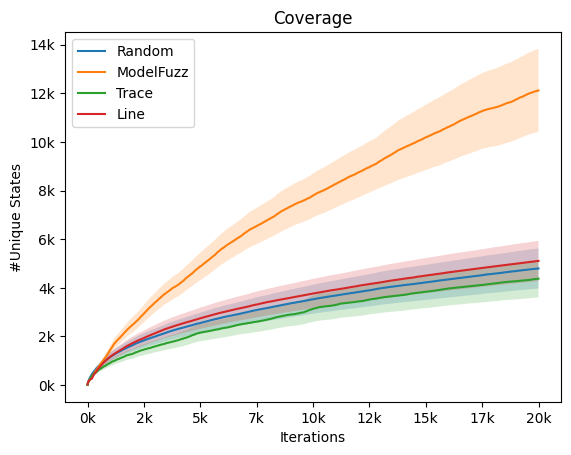

In [20]:
fig, ax = plt.subplots()

colors = {
    "Random": "tab:blue",
    "ModelFuzz": "tab:orange",
    "Trace": "tab:green",
    "Line": "tab:red"
}

for (b, bands) in coverages_plot.items():
    ax.plot(np.arange(len(bands[0])), bands[2], label=b, color=colors[b])
    ax.fill_between(np.arange(len(bands[0])), bands[0], bands[1], alpha=0.2)

ax.set_xlabel('Iterations')
ax.set_ylabel('#Unique States')
ax.set_title("Coverage")
ax.legend()

# ax.set_xticks(ax.get_xticks())
ax.set_xticklabels([str(int(x/1000))+"k" for x in ax.get_xticks()])
# ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([str(int(y/1000))+"k" for y in ax.get_yticks()])

# plt.show()
plt.savefig("redis-compare.pdf")

In [23]:
tlc_final_avg_cov = [int(cov[-1]) for cov in coverages["tlc"]]
for guidance, covs in coverages.items():
    if guidance == "tlc":
        continue
    g_cov = [int(cov[-1]) for cov in covs]
    print("{}\n{}".format(tlc_final_avg_cov, g_cov))
    u, p = mannwhitneyu(tlc_final_avg_cov, g_cov, alternative="greater")
    print("tlc vs {}: {}({})".format(guidance, u, p))

[5706, 4636, 6396, 6610, 5610, 4800, 9323, 8450, 8603, 8703, 9197, 8638, 8516, 10216, 10022, 12525, 33147, 26838, 26870, 27458]
[2355, 2359, 2291, 2027, 2139, 2049, 3199, 3077, 3073, 3103, 3118, 3134, 3010, 3066, 2984, 3026, 13126, 12900, 13095, 12796]
tlc vs random: 336.0(0.00012353065066114758)
[5706, 4636, 6396, 6610, 5610, 4800, 9323, 8450, 8603, 8703, 9197, 8638, 8516, 10216, 10022, 12525, 33147, 26838, 26870, 27458]
[2223, 2099, 1985, 1930, 1917, 1849, 2465, 2937, 2477, 2803, 2653, 2660, 2805, 2851, 2693, 3053, 12094, 11984, 11972, 12087]
tlc vs trace: 340.0(8.049066982959198e-05)
[5706, 4636, 6396, 6610, 5610, 4800, 9323, 8450, 8603, 8703, 9197, 8638, 8516, 10216, 10022, 12525, 33147, 26838, 26870, 27458]
[2002, 2152, 2220, 2957, 3035, 3011, 3065, 3099, 3046, 3053, 2953, 2969, 3170, 12422, 12395, 12704, 12560]
tlc vs line: 278.0(0.0005261063183682643)


In [11]:
print("Averages")
for k in branch_coverages:
    print(" {}: {}, {}".format(rev_map[k], branch_coverages[k], [i for i in branch_coverages[k] if i > 10]))
    avg = np.mean([i for i in branch_coverages[k] if i > 10])
    std = np.std([i for i in branch_coverages[k] if i > 10])
    print(" {}: {} +/- {}".format(rev_map[k], avg, std))

print("Mann-Whitney U test")
tlc_branch_coverage = branch_coverages["tlc"]
for k in branch_coverages:
    if k == "tlc":
        continue
    u, p = mannwhitneyu(tlc_branch_coverage, branch_coverages[k])
    print(" tlc vs. {}: {} (p={})".format(k, u, p))
    if p > 0.05:
        print(" reject the hypothesis that tlc is different from {}".format(k))

Averages
 Random: [128, 236, 0, 92, 114, 90, 118, 134, 50, 385, 170, 160, 183, 115], [128, 236, 92, 114, 90, 118, 134, 50, 385, 170, 160, 183, 115]
 Random: 151.92307692307693 +/- 81.055974523271
 ModelFuzz: [246, 108, 270, 99, 84, 4, 111, 78, 71, 294, 78, 0, 338, 307], [246, 108, 270, 99, 84, 111, 78, 71, 294, 78, 338, 307]
 ModelFuzz: 173.66666666666666 +/- 101.84738037322751
 Trace: [87, 222, 0, 366, 88, 150, 19, 352, 79, 125, 170, 246, 62, 149], [87, 222, 366, 88, 150, 19, 352, 79, 125, 170, 246, 62, 149]
 Trace: 162.69230769230768 +/- 103.23638641142928
 Line: [167, 287, 334, 27, 65, 71, 284, 177, 76, 146, 244, 49, 83, 99], [167, 287, 334, 27, 65, 71, 284, 177, 76, 146, 244, 49, 83, 99]
 Line: 150.64285714285714 +/- 97.02989755950567
Mann-Whitney U test
 tlc vs. random: 86.5 (p=0.6131635608490871)
 reject the hypothesis that tlc is different from random
 tlc vs. trace: 92.0 (p=0.8004103683274278)
 reject the hypothesis that tlc is different from trace
 tlc vs. line: 102.0 (p=0.872

## Coverage Statistical tests

In [25]:
tlc_final_coverages = [cov[-1] for cov in coverages["tlc"]]
for k in coverages:
    if k == "tlc":
        continue
    u, p = mannwhitneyu(tlc_final_coverages, [cov[-1] for cov in coverages[k]], alternative="greater")
    print(" tlc vs. {}: {} (p={})".format(k, u, p))
    if p > 0.05:
        print(" reject the hypothesis that tlc is different from {}".format(k))

 tlc vs. random: 313.0 (p=5.8171495316575396e-05)
 tlc vs. trace: 316.0 (p=4.052213874239574e-05)
 tlc vs. line: 258.0 (p=0.00023840747963736552)


## Unused stuff related to assertions

In [ ]:
no_assertion_bug_cat = {}
for k, v in no_assertion_fail_stack_traces.items():
    bug_classes = get_bug_class(v["trace"])
    if "ignore" in bug_classes:
        continue
    
    for bug_class in bug_classes:
        if bug_class not in no_assertion_bug_cat:
            no_assertion_bug_cat[bug_class] = {
                "occurrences": [],
                "stack_traces": [],
            }
        no_assertion_bug_cat[bug_class]["occurrences"] += v["occurrences"]
        no_assertion_bug_cat[bug_class]["stack_traces"].append(v["trace"])

with open("no_assertion_fail_bugs.json", "w") as bugs_file:
    json.dump(no_assertion_bug_cat, bugs_file, indent=4)

In [ ]:
no_assertion_fail_stack_traces = {}

for (r, cat, iter) in all_assertion_failures["NO_ASSERTION_FAILURE"]:
    with open(os.path.join("new_experiments", str(r), "{}_{}.log".format(cat, iter)), encoding = "ISO-8859-1") as log:
        log_lines = log.readlines()
        stack_traces = get_stack_trace(log_lines)
        for key, stack_trace in stack_traces:
            if key == 0:
                continue
            full_trace = "".join(stack_trace)
            if "testSendMemberShipEvent" in full_trace:
                continue
            if key not in no_assertion_fail_stack_traces:
                no_assertion_fail_stack_traces[key] = {
                    "occurrences": [],
                    "trace": stack_trace,
                }
            no_assertion_fail_stack_traces[key]["occurrences"].append((r, cat, iter))

len(no_assertion_fail_stack_traces.keys())

KeyboardInterrupt: 

In [ ]:
assertion_failure_bug_class = {}

for key, occurrences in all_assertion_failures.items():
    if key == "NO_ASSERTION_FAILURE":
        continue
    for (r, cat, iter) in occurrences:
        with open(os.path.join("new_experiments", str(r), "{}_{}.log".format(cat, iter)), encoding = "ISO-8859-1") as log:
            log_lines = log.readlines()
            stack_traces = get_stack_trace(log_lines)
            for trace_key, stack_trace in stack_traces:
                if trace_key == 0:
                    continue
                bug_classes = get_bug_class(stack_trace)
                if "ignore" in bug_classes:
                    continue
                for bug_class in bug_classes:
                    if key not in assertion_failure_bug_class:
                        assertion_failure_bug_class[key] = set()
                    assertion_failure_bug_class[key].add(bug_class)

for key, bug_classes in assertion_failure_bug_class.items():
    print("{}\n\t{}".format(key, bug_classes))

redis-server: /home/snagendra/Fuzzing/redisraft-fuzzing/deps/raft/src/raft_server.c:1702: raft_get_first_entry_idx: Assertion `0 < raft_get_current_idx(me)' failed.

	{'raft_become_follower', 'raft_get_entry_from_idx', 'handleBeforeSleep', 'raft_restore_log', 'raft_set_current_term', 'raft_apply_entry', 'raft_append_entry', 'unclassified', 'ConnIsConnected'}
 ==> /home/snagendra/Fuzzing/redisraft-fuzzing/src/log.c:509 'ety != NULL' is not true

	{'raft_become_follower', 'raft_get_entry_from_idx', 'handleBeforeSleep', 'raft_delete_entry_from_idx', 'raft_restore_log', 'raft_apply_entry', 'raft_append_entry', 'unclassified', 'ConnIsConnected'}
redis-server: /home/snagendra/Fuzzing/redisraft-fuzzing/deps/raft/src/raft_server.c:286: raft_handle_append_cfg_change: Assertion `!node || !raft_node_is_voting(node)' failed.

	{'raft_become_follower', 'raft_get_entry_from_idx', 'raft_restore_log', 'raft_apply_entry', 'raft_append_entry', 'unclassified'}
redis-server: rax.c:1244: raxFreeWithCallbac

In [ ]:
for key, occurrences in all_assertion_failures.items():
    print("{}: {}".format(key, len(occurrences)))


NO_ASSERTION_FAILURE: 29114
redis-server: /home/snagendra/Fuzzing/redisraft-fuzzing/deps/raft/src/raft_server.c:1702: raft_get_first_entry_idx: Assertion `0 < raft_get_current_idx(me)' failed.
: 93556
 ==> /home/snagendra/Fuzzing/redisraft-fuzzing/src/log.c:509 'ety != NULL' is not true
: 33478
redis-server: /home/snagendra/Fuzzing/redisraft-fuzzing/deps/raft/src/raft_server.c:286: raft_handle_append_cfg_change: Assertion `!node || !raft_node_is_voting(node)' failed.
: 748
redis-server: rax.c:1244: raxFreeWithCallback: Assertion `rax->numnodes == 0' failed.
: 178
redis-server: /home/snagendra/Fuzzing/redisraft-fuzzing/deps/raft/src/raft_server.c:279: raft_handle_append_cfg_change: Assertion `node' failed.
: 2237
Inconsistency detected by ld.so: dl-open.c: 211: _dl_find_dso_for_object: Assertion `ns == l->l_ns' failed!
: 33
redis-server: /home/snagendra/Fuzzing/redisraft-fuzzing/deps/raft/src/raft_server.c:295: raft_handle_append_cfg_change: Assertion `!raft_node_is_voting(node)' failed

In [ ]:
assertion_stats = {}

for key, occurrences in all_assertion_failures.items():
    if key not in assertion_stats:
        assertion_stats[key] = {
            "runs": {},
            "first_occur": {},
            "avg_first_occur": {}
        }
    first_occur = {}
    found_runs = {}
    for (r, cat, iter) in occurrences:
        if cat not in found_runs:
            found_runs[cat] = set()
        found_runs[cat].add(r)
        if cat not in first_occur:
            first_occur[cat] = {}
        if r not in first_occur[cat]:
            first_occur[cat][r] = int(iter)
        else:
            first_occur[cat][r] = min(first_occur[cat][r], int(iter))
    
    print(key+":")
    for cat, runs in found_runs.items():
        assertion_stats[key]["runs"][cat] = len(runs)
        print("\t{}: {}".format(cat, len(runs)))
    
    for cat, first_occur_runs in first_occur.items():
        avg = np.mean(list(first_occur_runs.values()))
        assertion_stats[key]["first_occur"][cat] = list(first_occur_runs.values())
        assertion_stats[key]["avg_first_occur"][cat] = avg
        print("\t{}: {}".format(cat, avg))

NO_ASSERTION_FAILURE:
	trace: 19
	tlc: 19
	random: 19
	line: 16
	trace: 136.0
	tlc: 137.6315789473684
	random: 157.1578947368421
	line: 146.625
redis-server: /home/snagendra/Fuzzing/redisraft-fuzzing/deps/raft/src/raft_server.c:1702: raft_get_first_entry_idx: Assertion `0 < raft_get_current_idx(me)' failed.
:
	tlc: 19
	trace: 19
	random: 19
	line: 16
	tlc: 64.78947368421052
	trace: 32.526315789473685
	random: 21.0
	line: 70.75
 ==> /home/snagendra/Fuzzing/redisraft-fuzzing/src/log.c:509 'ety != NULL' is not true
:
	tlc: 19
	random: 19
	trace: 19
	line: 16
	tlc: 136.42105263157896
	random: 122.47368421052632
	trace: 245.57894736842104
	line: 163.1875
redis-server: rax.c:1244: raxFreeWithCallback: Assertion `rax->numnodes == 0' failed.
:
	trace: 6
	tlc: 6
	random: 6
	line: 3
	trace: 2666.1666666666665
	tlc: 414.6666666666667
	random: 2207.1666666666665
	line: 1742.6666666666667
redis-server: /home/snagendra/Fuzzing/redisraft-fuzzing/deps/raft/src/raft_server.c:279: raft_handle_append_cfg

In [ ]:
# if "FileFlush" in trace_str:
#     bug_class = "FileFlush" # done
# elif "raft_restore_log" in trace_str:
#     bug_class = "raft_restore_log" # done
# elif "raft_get_entry_from_idx" in trace_str or "raft_get_last_log_term" in trace_str:
#     bug_class = "raft_get_entry_from" # done
# # elif ("raft_get_entry_from_idx" in trace_str or "raft_get_last_log_term" in trace_str) and "raft_recv_appendentries" in trace_str:
# #     bug_class = "raft_get_entry_from_idx_appendentries"
# # elif "raft_delete_entry_from_idx" in trace_str and "raft_recv_appendentries" in trace_str:
# #     bug_class = "raft_delete_entry_from_idx_appendentries"
# # elif "raft_get_entry_from_idx" in trace_str:
# #     bug_class = "raft_get_entry_from_idx"
# elif "raft_become_follower" in trace_str:
#     bug_class = "raft_become_follower" # done
# elif "raft_node_get_id" in trace_str:
#     bug_class = "raft_node_get_id" # done
# elif "raft_handle_apply_cfg_change" in trace_str or "raft_handle_append_cfg_change" in trace_str:
#     bug_class = "raft_handle_apply_cfg_change" # done
# elif "raft_node_set_snapshot_offset" in trace_str:
#     bug_class = "raft_node_set_snapshot_offset"
# elif "ConnIsConnected" in trace_str or "HandleNodeStates" in trace_str:
#     bug_class = "ConnIsConnected" # done
# elif "clientsCron" in trace_str or "serverCron" in trace_str:
#     bug_class = "clientsCron" # done
# elif "raft_set_current_term" in trace_str and "raft_recv_requestvote" in trace_str:
#     bug_class = "raft_set_current_term_requestvote"
# elif "raft_set_current_term" in trace_str and "raft_recv_appendentries" in trace_str:
#     bug_class = "raft_set_current_term_appendentries"
# elif "raft_entry_new" in trace_str:
#     bug_class = "raft_entry_new"
# elif "raft_recv_appendentries" in trace_str and "raft_append_entry" in trace_str:
#     bug_class = "raft_recv_appendentries_raft" 
# elif "mg_call" in trace_str or "redisOutOfMemoryHandler" in trace_str:
#     bug_class = "ignore"
# elif "_serverAssert" in trace_str or "modulesCollectInfo" in trace_str or "mg_mgr_poll" in trace_str or "redis_test_http_do" in trace_str or "printCrashReport" in trace_str:
#     bug_class = "ignore"   
# elif len(v["trace"]) <=2:
#     bug_class = "ignore"
# elif "redisraft.so" not in trace_str or "libjson-c.so" in trace_str:
#     bug_class = "ignore"
# elif "deserializeAEReq" in trace_str and "RM_Calloc" in trace_str and ("je_calloc" in trace_str or "je_malloc_usable_size" in trace_str):
#     bug_class = "ignore"
# elif "get_message_id" in trace_str and ",redis_test_" in trace_str:
#     bug_class = "ignore"
# elif "callRaftPeriodic" in trace_str or "moduleTimerHandler" in trace_str:
#     bug_class = "ignore"